<a href="https://colab.research.google.com/github/MengOonLee/BertelsmannAITrack/blob/LunarNewYear/Chinese-Zodiac-Signs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Colab library to upload files to notebook
from google.colab import files

In [2]:
# Rerun this cell again
# Upload your kaggle API key file
uploaded = files.upload()

Saving kaggle.json to kaggle (1).json


In [3]:
# Install Kaggle library
# Make kaggle directory and downlaod data for the Lunar New Year challenge
# Unzip the downloaded folder
%%bash

pip3 install -q kaggle nonechucks
rm -rf ~/.kaggle signs *.zip *.pt
mkdir -p ~/.kaggle
mv kaggle.json ~/.kaggle/
kaggle datasets download -d elderyouth/chinese-zodiac-signs
unzip -q chinese-zodiac-signs.zip
rm -rf chinese-zodiac-signs.zip

100%|##########| 2.07G/2.07G [00:28<00:00, 77.2MB/s]


In [4]:
import torch

# Check if CUDA is available
train_on_gpu = torch.cuda.is_available()

# Move the model to GPU if CUDA is available
if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [5]:
import numpy as np
import nonechucks
from torchvision import datasets, transforms

# Define transforms, rezise, rotate slightly, preform horizontal flip

data_dir = 'signs'

mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

# Define transforms for the train, valid & test data
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize(mean, std)])

test_transforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean, std)])

# Pass transforms in here, then run the next cell to see how the transforms look
train_data = datasets.ImageFolder(data_dir + '/train', 
                                  transform=train_transforms)
train_data = nonechucks.SafeDataset(train_data)
valid_data = datasets.ImageFolder(data_dir + '/valid', 
                                 transform=test_transforms)
valid_data = nonechucks.SafeDataset(valid_data)
test_data = datasets.ImageFolder(data_dir + '/test', 
                                 transform=test_transforms)
test_data = nonechucks.SafeDataset(test_data)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=32, shuffle=True)

nonechucks may not work properly with this version of PyTorch (1.3.1). It has only been tested on PyTorch versions 1.0, 1.1, and 1.2


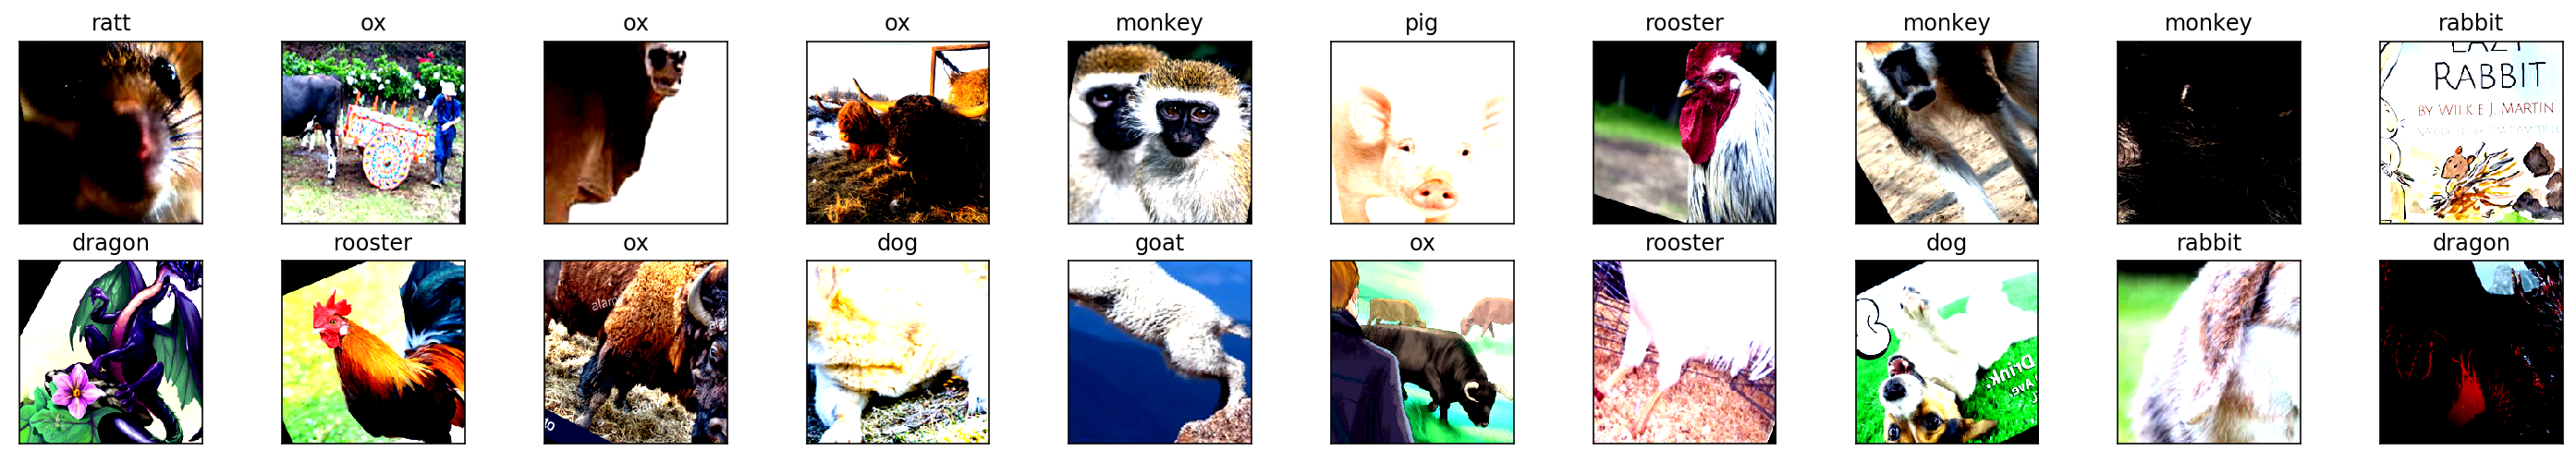

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# specify the image classes
classes = train_data.classes

# helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    img = np.clip(img, 0, 1)
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

In [0]:
# Load Resnet50 model

from torchvision import models
from torch import nn
import torch.nn.functional as F

resnet50 = models.resnet50(pretrained=True)

# freeze resnet50 feature parameters
for param in resnet50.parameters():
    param.requires_grad = False

# Define our new classifier
classifier = nn.Sequential(
  nn.Linear(2048, 512),
  nn.ReLU(),
  nn.Dropout(p=0.2),
  nn.Linear(512, 12),
  nn.LogSoftmax(dim=1)
)

resnet50.fc = classifier

if train_on_gpu:
    resnet50.cuda()

## Train the Network¶

Remember to look at how the training and validation loss decreases over time; if the validation loss ever increases it indicates possible overfitting.

In [8]:
from torch import optim

# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# specify optimizer
optimizer = optim.Adam(resnet50.fc.parameters(), lr=0.003)

# number of epochs to train the model
epochs = 10

valid_loss_min = np.Inf # track change in validation loss

for epoch in range(epochs):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    resnet50.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = resnet50(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    resnet50.eval()
    for batch_idx, (data, target) in enumerate(valid_loader):
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = resnet50(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(resnet50.state_dict(), 'Resnet50_LunarNewYear.pt')
        valid_loss_min = valid_loss

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch: 0 	Training Loss: 0.947107 	Validation Loss: 0.345033
Validation loss decreased (inf --> 0.345033).  Saving model ...
Epoch: 1 	Training Loss: 0.555604 	Validation Loss: 0.279477
Validation loss decreased (0.345033 --> 0.279477).  Saving model ...
Epoch: 2 	Training Loss: 0.505240 	Validation Loss: 0.254782
Validation loss decreased (0.279477 --> 0.254782).  Saving model ...
Epoch: 3 	Training Loss: 0.486753 	Validation Loss: 0.292139
Epoch: 4 	Training Loss: 0.446264 	Validation Loss: 0.295481
Epoch: 5 	Training Loss: 0.440526 	Validation Loss: 0.258592
Epoch: 6 	Training Loss: 0.417438 	Validation Loss: 0.311808
Epoch: 7 	Training Loss: 0.400913 	Validation Loss: 0.318486
Epoch: 8 	Training Loss: 0.369464 	Validation Loss: 0.291839
Epoch: 9 	Training Loss: 0.363543 	Validation Loss: 0.300726


In [9]:
# Load the Model with the Lowest Validation Loss
resnet50.load_state_dict(torch.load('Resnet50_LunarNewYear.pt'))

<All keys matched successfully>

## Test the Trained Network

Test your trained model on previously unseen data!

In [10]:
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(12))
class_total = list(0. for i in range(12))

resnet50.eval()
# iterate over test data
for batch_idx, (data, target) in enumerate(test_loader):
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = resnet50(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(12):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Test Loss: 0.270980

Test Accuracy of   dog: 83% (15/18)
Test Accuracy of dragon: 100% (21/21)
Test Accuracy of  goat: 93% (14/15)
Test Accuracy of horse: 92% (23/25)
Test Accuracy of monkey: 95% (23/24)
Test Accuracy of    ox: 88% (15/17)
Test Accuracy of   pig: 100% (23/23)
Test Accuracy of rabbit: 87% (14/16)
Test Accuracy of  ratt: 86% (19/22)
Test Accuracy of rooster: 78% (18/23)

Test Accuracy (Overall): 90% (228/252)


## Visualize Sample Test Results

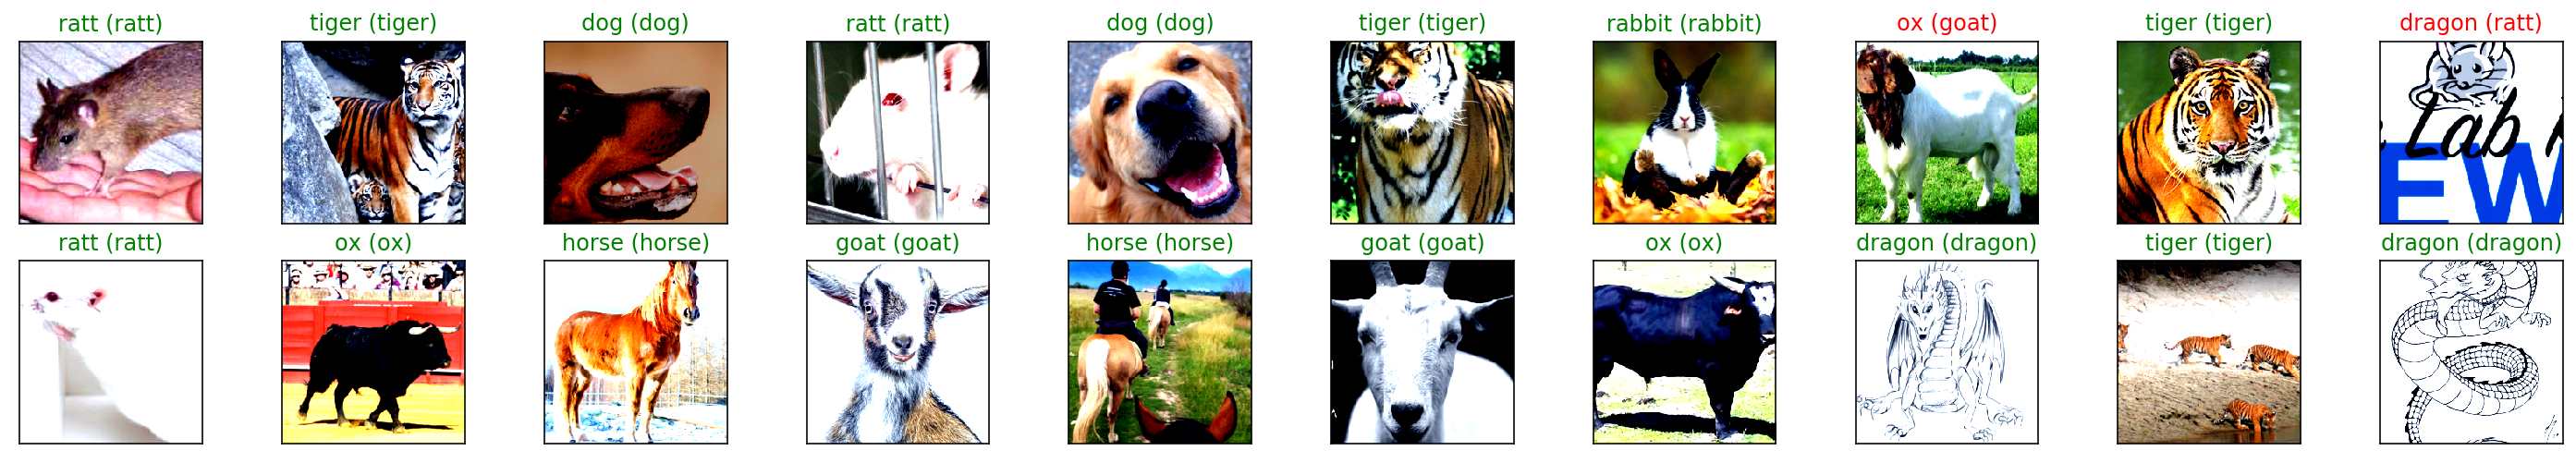

In [11]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
images.numpy()

# move model inputs to cuda, if GPU available
if train_on_gpu:
    images = images.cuda()

# get sample outputs
output = resnet50(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images.cpu()[idx])
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))